## Predictive Modeling for Credit Default Payments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.3 MB/s eta 0:00:00


In [6]:
# Load data
data = pd.read_csv('UCI_Credit_Card.csv')

# Display initial data
print(data.head())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0   

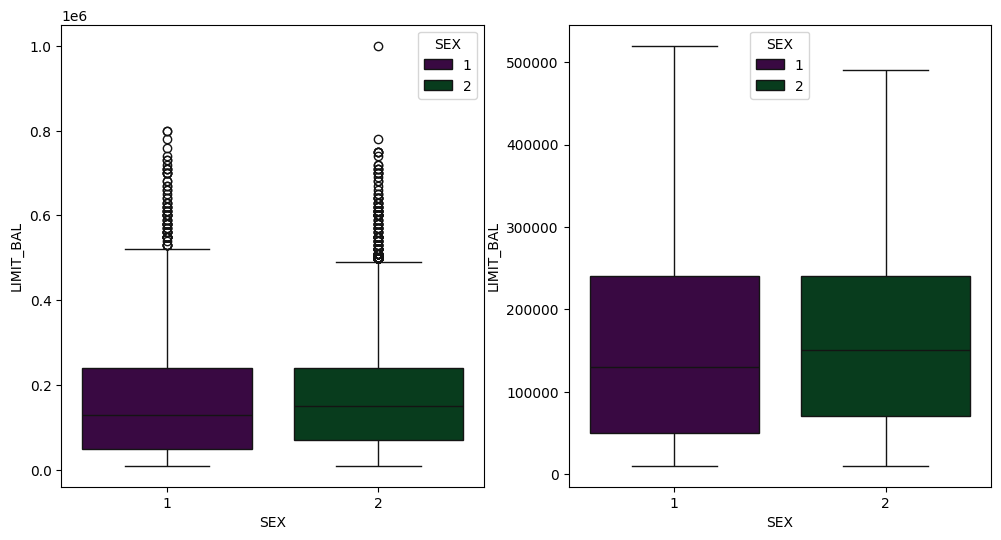

In [7]:
# Boxplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.boxplot(ax=ax1, x="SEX", y="LIMIT_BAL", hue="SEX", data=data, palette="PRGn", showfliers=True)
sns.boxplot(ax=ax2, x="SEX", y="LIMIT_BAL", hue="SEX", data=data, palette="PRGn", showfliers=False)
plt.show()

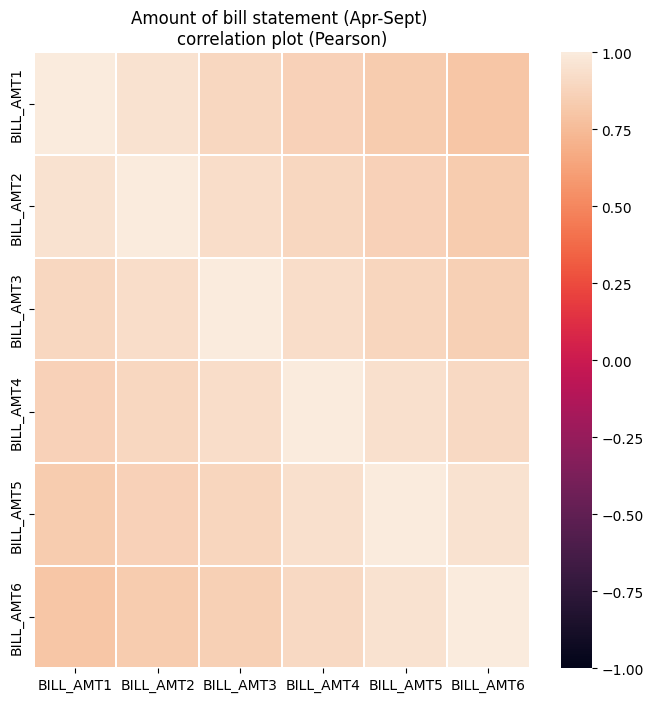

In [8]:
# Correlation plots
var = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
plt.show()

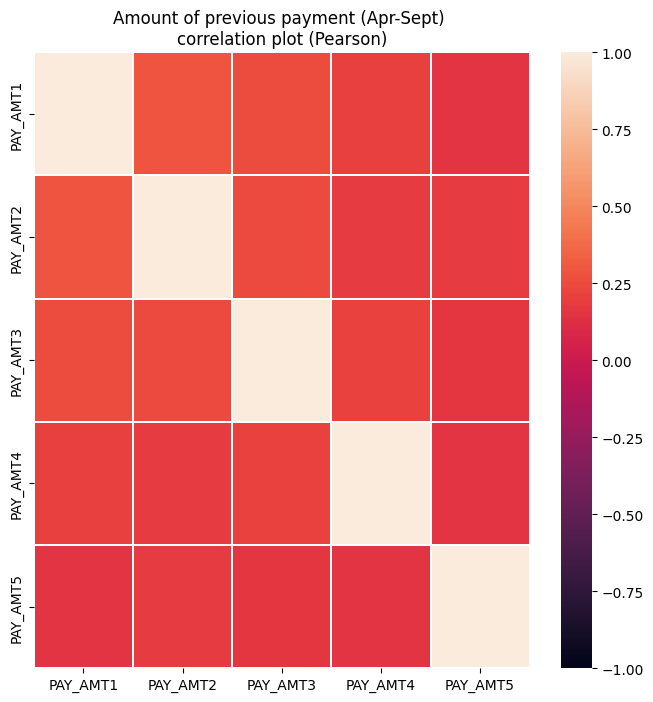

In [9]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']
plt.figure(figsize=(8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
plt.show()

In [10]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    sns.boxplot(ax=ax1, x=feature1, y=feature2, hue=feature3, data=data, palette="PRGn", showfliers=False)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    plt.show()


<ipython-input-10-4ac43c09ee06>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


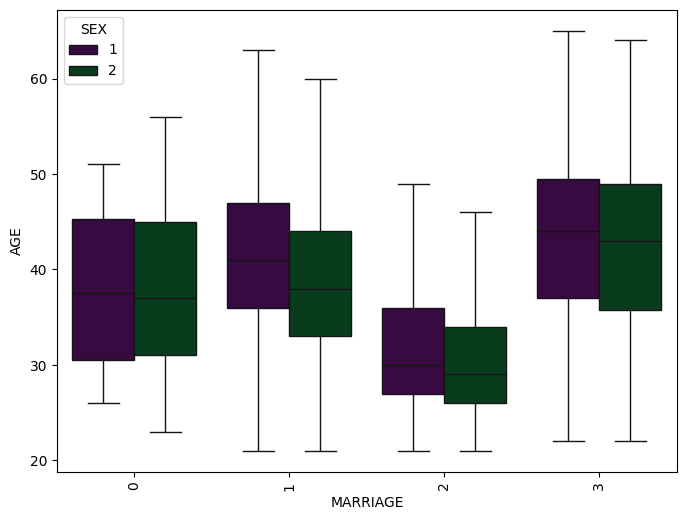

<ipython-input-10-4ac43c09ee06>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


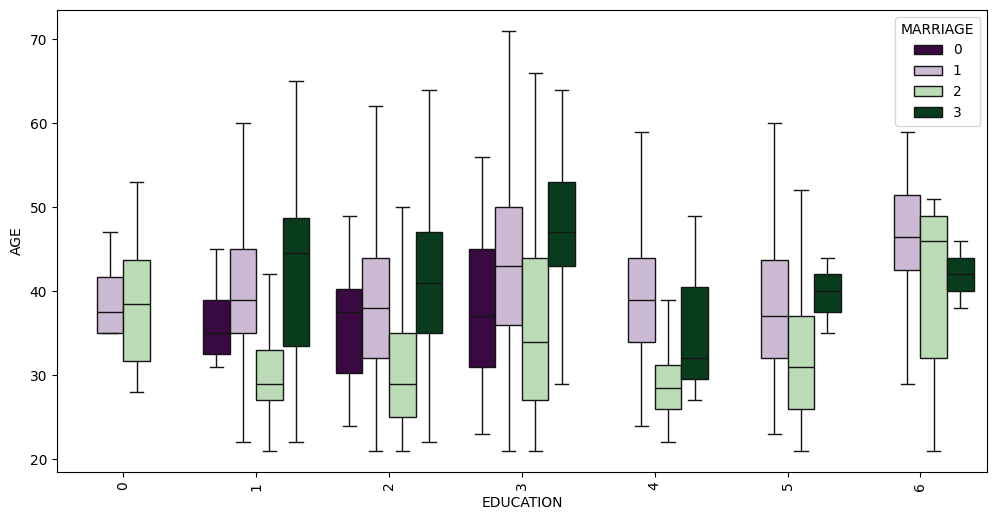

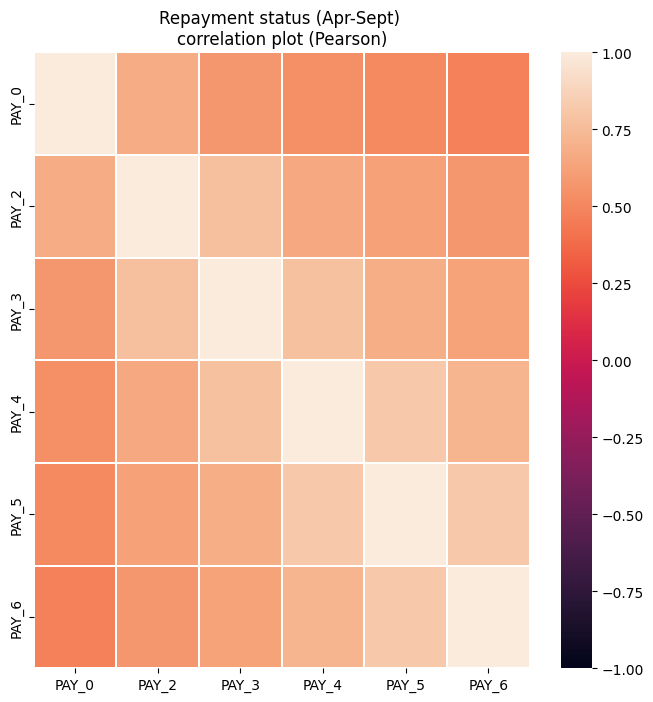

In [11]:
boxplot_variation('MARRIAGE', 'AGE', 'SEX', 8)
boxplot_variation('EDUCATION', 'AGE', 'MARRIAGE', 12)

var = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data[var].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
plt.show()


In [12]:
# Handle missing values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.transpose())

          ID  BILL_AMT2  PAY_AMT6  PAY_AMT5  PAY_AMT4  PAY_AMT3  PAY_AMT2  \
Total    0.0        0.0       0.0       0.0       0.0       0.0       0.0   
Percent  0.0        0.0       0.0       0.0       0.0       0.0       0.0   

         PAY_AMT1  BILL_AMT6  BILL_AMT5  ...  PAY_5  PAY_4  PAY_3  PAY_2  \
Total         0.0        0.0        0.0  ...    0.0    0.0    0.0    0.0   
Percent       0.0        0.0        0.0  ...    0.0    0.0    0.0    0.0   

         PAY_0  AGE  MARRIAGE  EDUCATION  SEX  default.payment.next.month  
Total      0.0  0.0       0.0        0.0  0.0                         0.0  
Percent    0.0  0.0       0.0        0.0  0.0                         0.0  

[2 rows x 25 columns]


In [13]:
# Features and target
target = 'default.payment.next.month'
predictors = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'AGE',
              'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [14]:
# Standardize the data
data1 = data[predictors]
scaler = StandardScaler()
dataa = scaler.fit_transform(data1)
dot = pd.DataFrame(data=dataa, columns=data1.columns)

In [15]:
# PCA
p = PCA()
x_pca = p.fit_transform(dot)
explained_variance = p.explained_variance_ratio_
num_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1  # Keep 95% variance
p = PCA(n_components=num_components)
new = pd.DataFrame(data=p.fit_transform(dot))

In [16]:
# VIF
vif = pd.DataFrame()
vif['features'] = new.columns
vif['VIF'] = [variance_inflation_factor(new.values, i) for i in range(new.shape[1])]
print(vif)

    features  VIF
0          0  1.0
1          1  1.0
2          2  1.0
3          3  1.0
4          4  1.0
5          5  1.0
6          6  1.0
7          7  1.0
8          8  1.0
9          9  1.0
10        10  1.0
11        11  1.0
12        12  1.0
13        13  1.0


In [17]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(new, data[target], test_size=0.3, random_state=42)
# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
print("RandomForest score:", rf.score(x_test, y_test))

RandomForest score: 0.8104444444444444


In [18]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(x_train, y_train)
print("AdaBoost score:", ada.score(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost score: 0.8068888888888889


In [19]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(x_train, y_train)
print("XGBoost score:", xgb_model.score(x_test, y_test))

XGBoost score: 0.8063333333333333


In [20]:
# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)
print("LightGBM score:", lgb_model.score(x_test, y_test))

[LightGBM] [Info] Number of positive: 4676, number of negative: 16324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222667 -> initscore=-1.250193
[LightGBM] [Info] Start training from score -1.250193
LightGBM score: 0.8127777777777778


In [25]:
# User input for prediction
user_input = {
    'LIMIT_BAL': float(input("Enter value for LIMIT_BAL: ")),
    'SEX': int(input("Enter value for SEX (1=male, 2=female): ")),
    'EDUCATION': int(input("Enter value for EDUCATION (1=graduate school, 2=university, 3=high school, 4=others): ")),
    'AGE': int(input("Enter value for AGE: ")),
    'PAY_0': int(input("Enter value for PAY_0: ")),
    'PAY_2': int(input("Enter value for PAY_2: ")),
    'PAY_3': int(input("Enter value for PAY_3: ")),
    'PAY_4': int(input("Enter value for PAY_4: ")),
    'PAY_5': int(input("Enter value for PAY_5: ")),
    'PAY_6': int(input("Enter value for PAY_6: ")),
    'BILL_AMT1': float(input("Enter value for BILL_AMT1: ")),
    'BILL_AMT2': float(input("Enter value for BILL_AMT2: ")),
    'BILL_AMT3': float(input("Enter value for BILL_AMT3: ")),
    'BILL_AMT4': float(input("Enter value for BILL_AMT4: ")),
    'BILL_AMT5': float(input("Enter value for BILL_AMT5: ")),
    'BILL_AMT6': float(input("Enter value for BILL_AMT6: ")),
    'PAY_AMT1': float(input("Enter value for PAY_AMT1: ")),
    'PAY_AMT2': float(input("Enter value for PAY_AMT2: ")),
    'PAY_AMT3': float(input("Enter value for PAY_AMT3: ")),
    'PAY_AMT4': float(input("Enter value for PAY_AMT4: ")),
    'PAY_AMT5': float(input("Enter value for PAY_AMT5: ")),
    'PAY_AMT6': float(input("Enter value for PAY_AMT6: "))
}

Enter value for LIMIT_BAL: 20000
Enter value for SEX (1=male, 2=female): 2
Enter value for EDUCATION (1=graduate school, 2=university, 3=high school, 4=others): 2
Enter value for AGE: 24
Enter value for PAY_0: 2
Enter value for PAY_2: 3
Enter value for PAY_3: -1
Enter value for PAY_4: -1
Enter value for PAY_5: -2
Enter value for PAY_6: -2
Enter value for BILL_AMT1: 3913
Enter value for BILL_AMT2: 3102
Enter value for BILL_AMT3: 689
Enter value for BILL_AMT4: 0
Enter value for BILL_AMT5: 0
Enter value for BILL_AMT6: 0
Enter value for PAY_AMT1: 0
Enter value for PAY_AMT2: 689
Enter value for PAY_AMT3: 0
Enter value for PAY_AMT4: 0
Enter value for PAY_AMT5: 0
Enter value for PAY_AMT6: 0


In [26]:
# Standardize and transform user input
user_input_df = pd.DataFrame(user_input, index=[0])
user_input_scaled = scaler.transform(user_input_df[predictors])
user_input_pca = p.transform(user_input_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [27]:
# Predict
ypred = lgb_model.predict(user_input_pca)
if ypred[0] == 0:
    print("Not Eligible")
else:
    print("Eligible")

Eligible
